In [1]:
#default_exp sr_unet

# fastai U-Net

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
import sys
sys.path.append('..')
from superres.datasets import *
from superres.databunch import *

In [5]:
seed = 8610
random.seed(seed)
np.random.seed(seed)

## DataBunch

In [6]:
train_hr = div2k_train_hr_crop_256

In [7]:
in_size = 256
out_size = 256
scale = 4
bs = 10

ImageDataBunch;

Train: LabelList (25245 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Valid: LabelList (6311 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Test: None


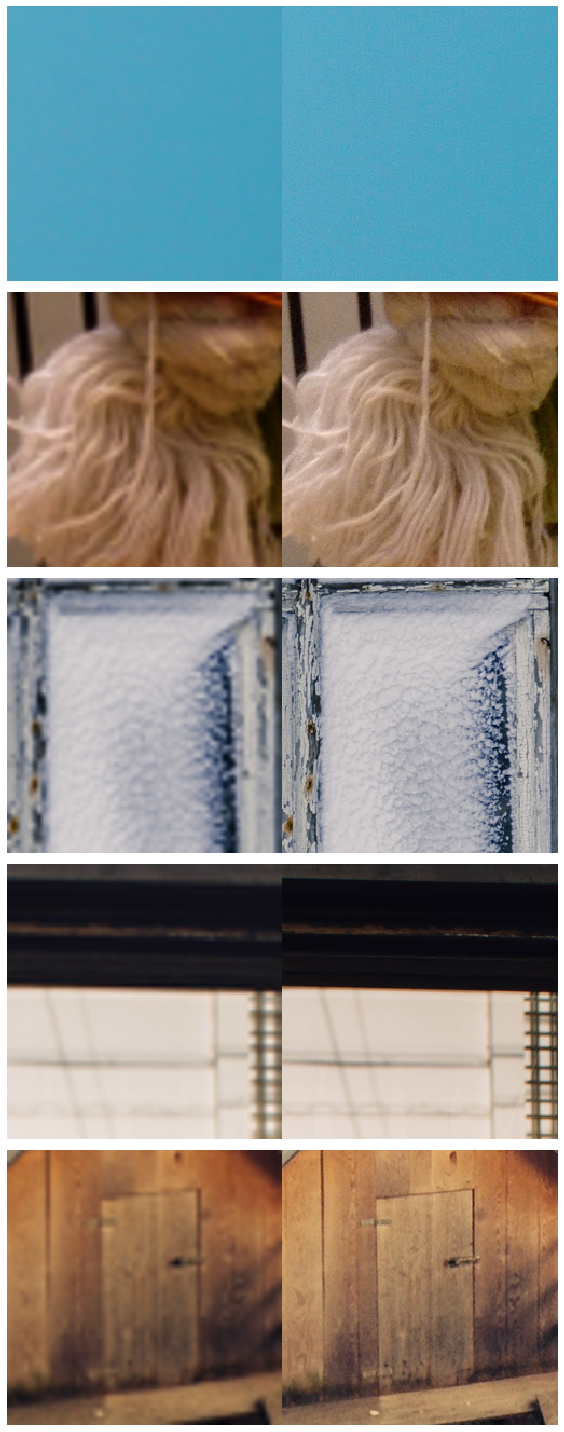

In [8]:
data = create_sr_databunch(train_hr, in_size=in_size, out_size=out_size, scale=scale, bs=bs, seed=seed)
print(data)
data.show_batch()

## Training

In [9]:
model = models.resnet34
loss_func = MSELossFlat()
metrics = [m_psnr, m_ssim]
wd = 1e-3
y_range = (-3.,3.)
model_name = 'sr_unet'

In [10]:
learn = unet_learner(data, model, wd=wd, metrics=metrics, y_range=y_range, loss_func=loss_func,
                     blur=True, norm_type=NormType.Weight, self_attention=True)
learn.path = Path('.')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.10E-01


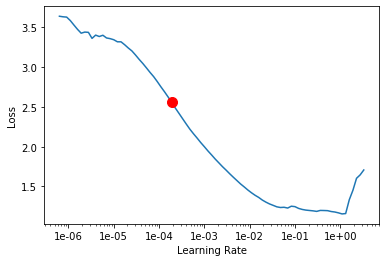

In [11]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [12]:
lr = 1e-3
lrs = slice(lr)
epoch = 3
pct_start = 0.3
wd = 1e-3
save_fname = model_name

In [13]:
callbacks = [ShowGraph(learn), SaveModelCallback(learn, name=save_fname)]

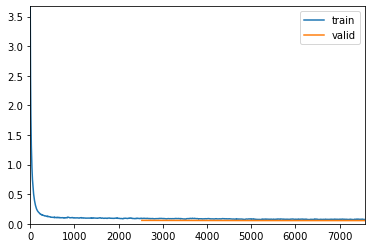

Better model found at epoch 0 with valid_loss value: 0.05740687996149063.
Better model found at epoch 1 with valid_loss value: 0.054548367857933044.
Better model found at epoch 2 with valid_loss value: 0.05399680882692337.


In [14]:
learn.fit_one_cycle(epoch, lrs, pct_start=pct_start, wd=wd, callbacks=callbacks)

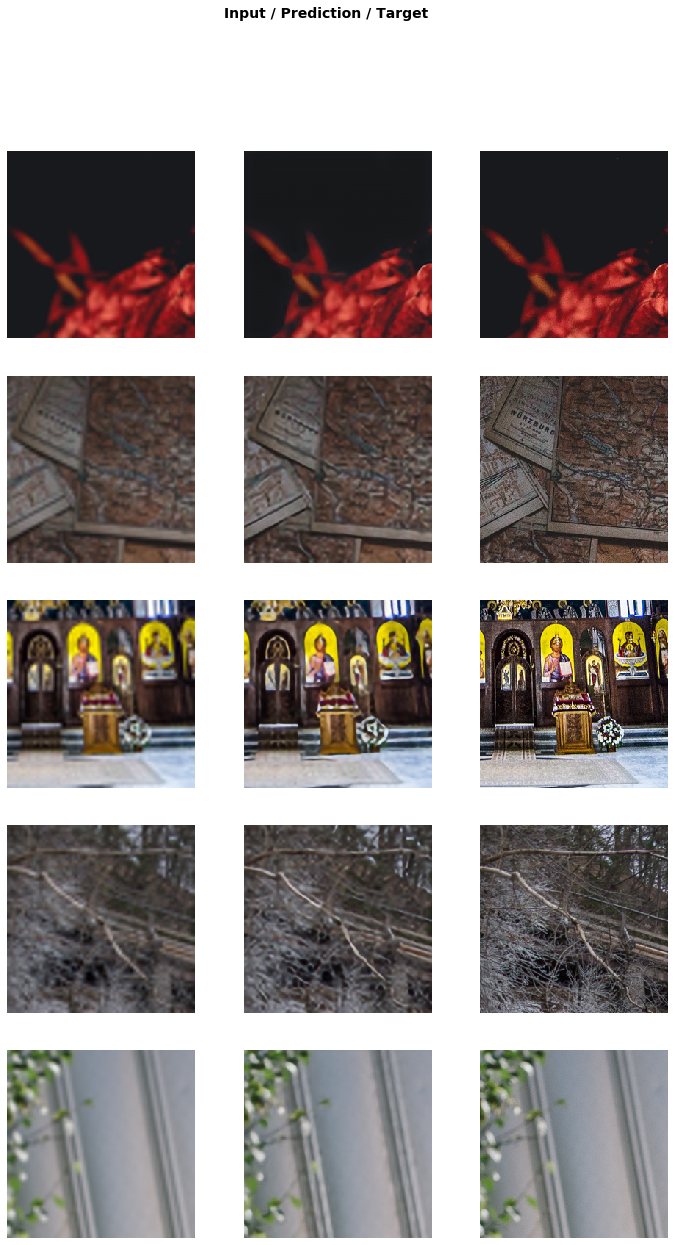

In [15]:
learn.show_results()

## Test

In [16]:
test_hr = set14_hr

In [25]:
il_test_x = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=in_size, scale=4, sizeup=True))
il_test_y = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=out_size))

In [26]:
_ = learn.load(save_fname)

bicubic: PSNR:24.11,SSIM:0.7822
sr_unet:	 PSNR:24.98,SSIM:0.8146


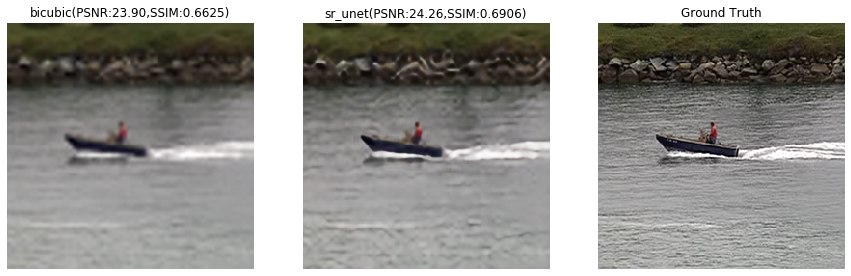

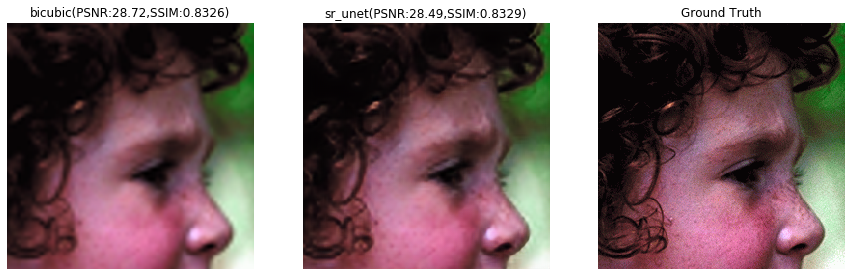

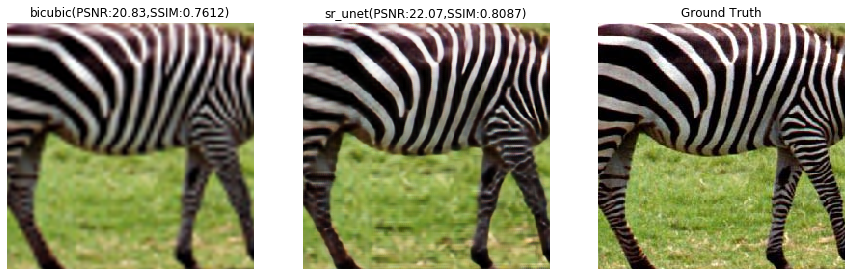

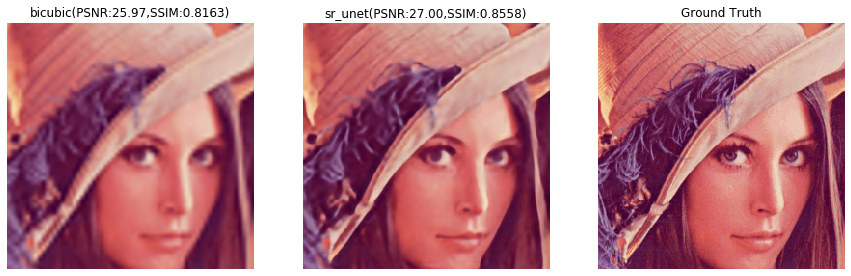

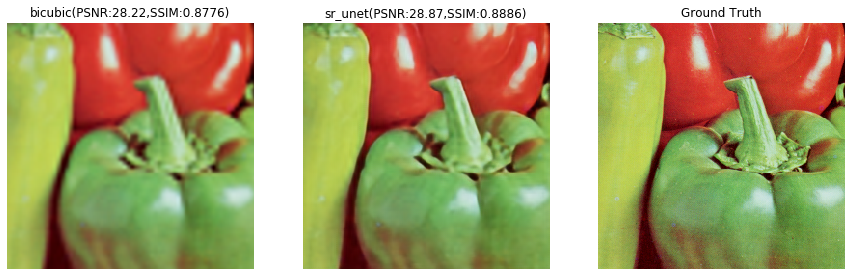

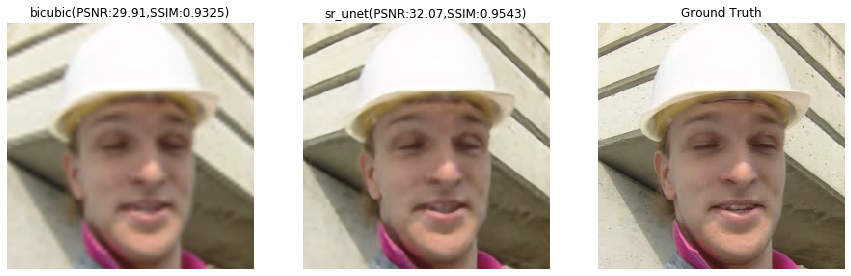

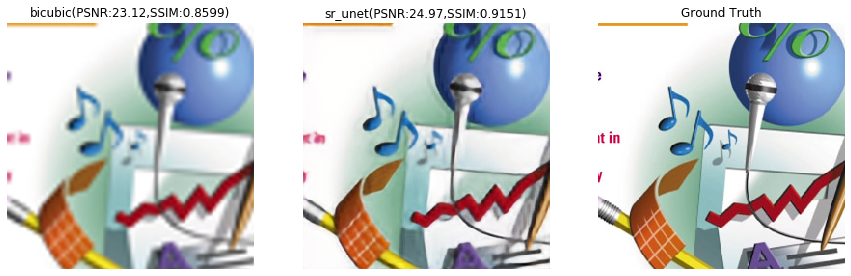

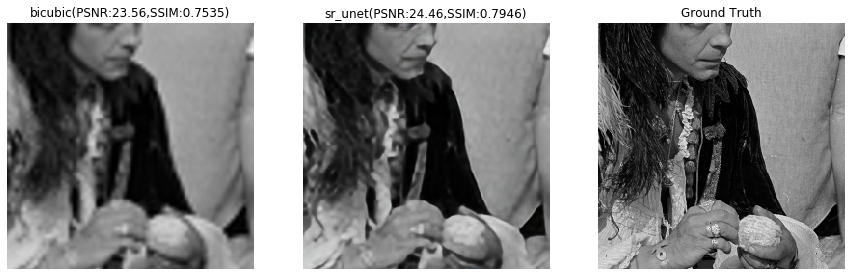

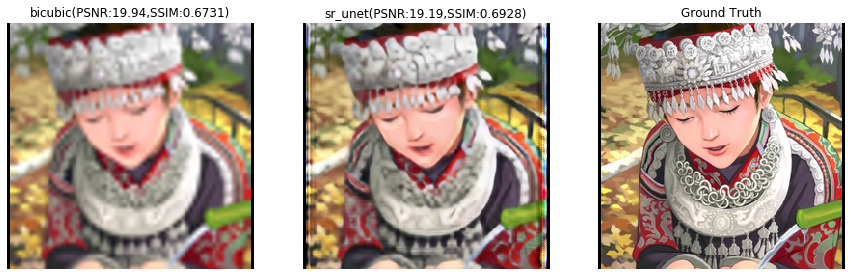

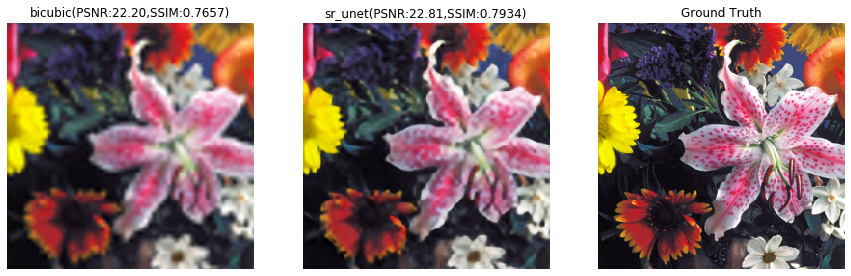

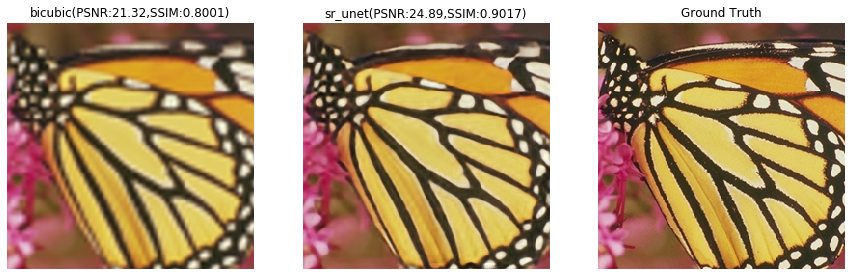

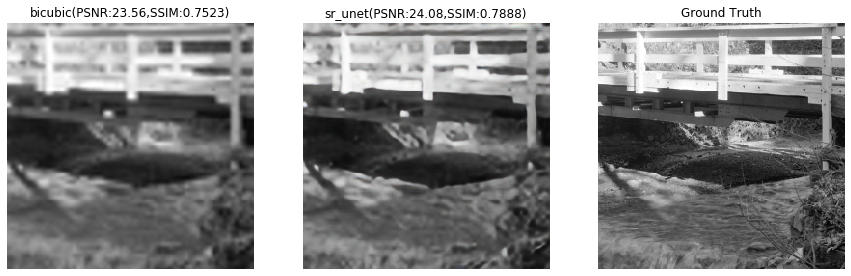

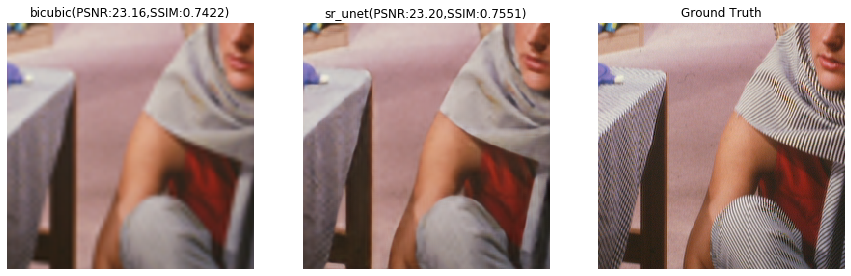

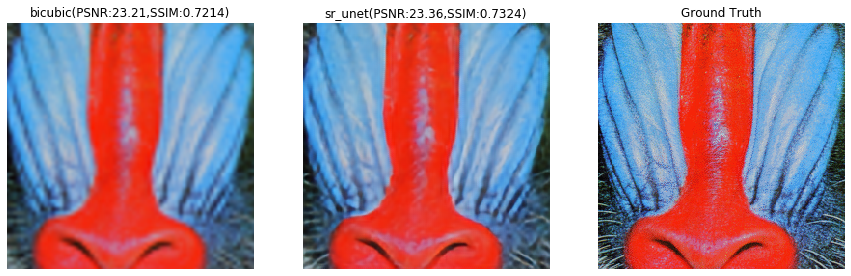

In [27]:
sr_test(learn, il_test_x, il_test_y, model_name)

## Report

In [28]:
model

<function torchvision.models.resnet.resnet34(pretrained=False, progress=True, **kwargs)>

In [29]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________